# Copula Demo

Before running, make sure the requirements have been installed correctly.

In [1]:
from jax import random
import jax.numpy as jnp

import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, HMC, MixedHMC
from numpyro.infer.reparam import TransformReparam

import matplotlib.pyplot as plt

/Users/danielmanela/.virtualenvs/test-env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# J = 8
# y = np.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0])
# sigma = np.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0])

In [3]:
# def eight_schools(J, sigma, y=None):
#     mu = numpyro.sample('mu', dist.Normal(0, 5))
#     tau = numpyro.sample('tau', dist.HalfCauchy(5))
    
#     with numpyro.plate('J', J):
#         theta = numpyro.sample('theta', dist.Normal(mu, tau))
#         numpyro.sample('obs', dist.Normal(theta, sigma), obs=y)

In [4]:
# def eight_schools_noncentered(J, sigma, y=None):
#     mu = numpyro.sample('mu', dist.Normal(0, 5))
#     tau = numpyro.sample('tau', dist.HalfCauchy(5))
    
#     with numpyro.plate('J', J):
#         with numpyro.handlers.reparam(config={'theta': TransformReparam()}):
#             theta = numpyro.sample(
#                 'theta',
#                 dist.TransformedDistribution(dist.Normal(0., 1.),
#                                              dist.transforms.AffineTransform(mu, tau))
#             )
#         numpyro.sample('obs', dist.Normal(theta, sigma), obs=y)

In [5]:
# nuts_kernel = NUTS(eight_schools_noncentered)
# mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=1000)
# rng_key = random.PRNGKey(0)
# mcmc.run(rng_key, J, sigma, y=y, extra_fields=('potential_energy',))

In [6]:
# #### Sampling without data
# def eight_schools_noncentered_no_data(J, sigma, y=None):
#     mu = numpyro.sample('mu', dist.Normal(0, 1))
#     tau = numpyro.sample('tau', dist.Gamma(concentration=5, rate=0.5))
    
#     with numpyro.plate('J', J):
#         with numpyro.handlers.reparam(config={'theta': TransformReparam()}):
#             theta = numpyro.sample(
#                 'theta',
#                 dist.TransformedDistribution(dist.Normal(0., 1.),
#                                              dist.transforms.AffineTransform(mu, tau))
#             )

In [7]:
# nuts_kernel_no_data = NUTS(eight_schools_noncentered_no_data)
# mcmc_no_data = MCMC(nuts_kernel_no_data, num_warmup=500, num_samples=2000)
# rng_key = random.PRNGKey(0)
# mcmc_no_data.run(rng_key, J, sigma, extra_fields=('potential_energy',))

In [8]:
# mcmc_no_data.print_summary()

## Do Discrete variables work with MixedHMC? (Yes they do)

In [9]:
def model(probs, locs):
    c = numpyro.sample("c", dist.Categorical(probs))
    numpyro.sample("x", dist.Normal(locs[c], 0.5))

probs = jnp.array([0.15, 0.3, 0.3, 0.25])
locs = jnp.array([-2, 0, 2, 4])
kernel = MixedHMC(HMC(model, trajectory_length=1.2), num_discrete_updates=20)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=100000, progress_bar=False)
mcmc.run(random.PRNGKey(0), probs, locs)

In [10]:
mcmc.print_summary()  
samples = mcmc.get_samples()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         c      1.65      1.02      2.00      0.00      3.00   8474.42      1.00
         x      1.29      2.09      1.51     -2.12      4.51   8898.92      1.00



## Copula 

In [11]:
def copula_lpdf(u, v, rho):
    u_2 = jnp.square(u)
    v_2 = jnp.square(v)
    rho_2 = jnp.square(rho)
    return (
        -0.5 * (1 - rho_2) - (
            rho_2 * (u_2 + v_2) - 2 * rho * u * v
        ) / (2 * (1 - rho_2))
    )

def simple_cts_copula_model(y=None):    
    Z = numpyro.sample('z', dist.Normal(0, 1))
    F_inv_Z = dist.Normal(0, 1).cdf(Z)
    
    X_mean = 0.1 * Z + 1
    X = numpyro.sample('x', dist.Normal(X_mean, 1))
    
    Y_mu = 0.1 * X
    Y = numpyro.sample('y', dist.Normal(Y_mu, 1))
    F_inv_Y = dist.Normal(Y_mu, 1).cdf(Y)
    
    numpyro.factor('cop_log_prob', copula_lpdf(F_inv_Z, F_inv_Y, 0.99999))
    
def simple_discrete_copula_model(y=None):    
    Z = numpyro.sample('z', dist.Normal(0, 1))
    F_inv_Z = dist.Normal(0, 1).cdf(Z)
    
    X_p = 1 / (1 + jnp.exp(-Z))
    X = numpyro.sample('x', dist.Bernoulli(X_p))
    
    Y_mu = 0.1 * X
    Y = numpyro.sample('y', dist.Normal(Y_mu, 1))
    F_inv_Y = dist.Normal(Y_mu, 1).cdf(Y)
    
    numpyro.factor('cop_log_prob', copula_lpdf(F_inv_Z, F_inv_Y, 0.99999))

### Continuous Copula Model

In [12]:
# Simple continuous copula
simple_cts_cop_kernel = HMC(simple_cts_copula_model)


mcmc_cts = MCMC(simple_cts_cop_kernel, num_warmup=1000, num_samples=2000, progress_bar=True)
mcmc_cts.run(random.PRNGKey(0))

sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:01<00:00, 1612.61it/s, 727 steps of size 8.65e-03. acc. prob=0.96]


In [13]:
mcmc_cts.print_summary()  
cts_samples = mcmc_cts.get_samples()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         x      1.08      0.97      1.09     -0.40      2.76     50.38      1.00
         y      0.31      1.04      0.32     -1.60      1.80    647.94      1.00
         z      0.20      1.02      0.21     -1.64      1.71    547.14      1.00

Number of divergences: 0


Mean: 1.0826010704040527. Var: 0.9397798776626587
Mean: 0.3125399947166443. Var: 1.0836108922958374
Mean: 0.2031058669090271. Var: 1.029729962348938


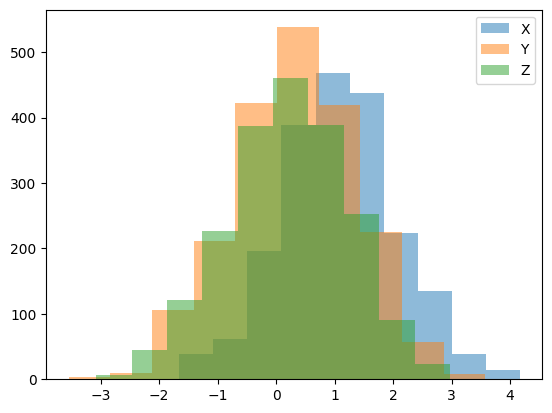

In [14]:
x_samp = cts_samples['x']
y_samp = cts_samples['y']
z_samp = cts_samples['z']

plt.hist(x_samp, label='X', alpha=0.5);
print(f"Mean: {np.mean(x_samp)}. Var: {np.var(x_samp)}")

plt.hist(y_samp, label='Y', alpha=0.5);
print(f"Mean: {np.mean(y_samp)}. Var: {np.var(y_samp)}")

plt.hist(z_samp, label='Z', alpha=0.5);
print(f"Mean: {np.mean(z_samp)}. Var: {np.var(z_samp)}")

plt.legend()

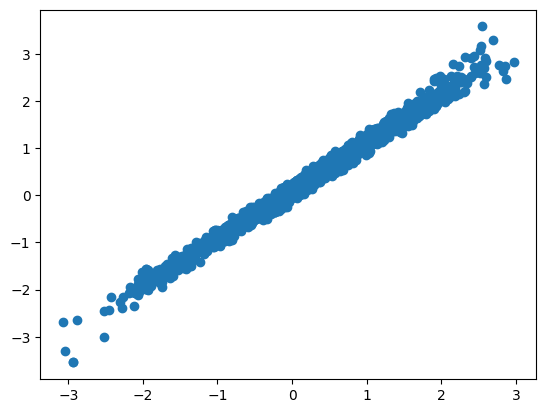

In [15]:
plt.scatter(z_samp, y_samp)

### Discrete Copula Model

In [16]:
# Simple discrete Copula
simple_discrete_cop_kernel = MixedHMC(HMC(simple_discrete_copula_model), num_discrete_updates=200)

mcmc_discrete = MCMC(simple_discrete_cop_kernel, num_warmup=1000, num_samples=2000, progress_bar=True)
mcmc_discrete.run(random.PRNGKey(0))

sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:02<00:00, 1022.09it/s, 798 steps of size 8.77e-03. acc. prob=0.96]


In [17]:
mcmc_discrete.print_summary()  
discrete_samples = mcmc_discrete.get_samples()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         x      0.56      0.50      1.00      0.00      1.00    238.49      1.00
         y      0.26      1.03      0.32     -1.34      2.03    594.83      1.00
         z      0.20      1.01      0.24     -1.37      1.96    627.42      1.00



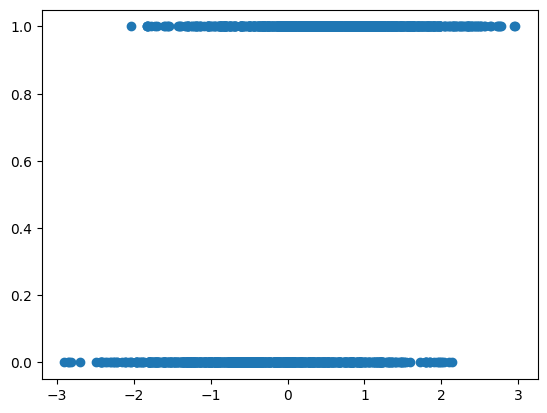

In [18]:
plt.scatter(discrete_samples['z'], discrete_samples['x'])

### Didilez Model

In [19]:
def copula_lpdf(u, v, rho):
    u_2 = jnp.square(u)
    v_2 = jnp.square(v)
    rho_2 = jnp.square(rho)
    return (
        -0.5 * (1 - rho_2) - (
            rho_2 * (u_2 + v_2) - 2 * rho * u * v
        ) / (2 * (1 - rho_2))
    )


def base_didilez_model(y=None):
    A = numpyro.sample("a", dist.Bernoulli(0.5))
    
    L_mu = jnp.exp(-(0.0 + 0.5 * A))
    L = numpyro.sample("l", dist.Exponential(L_mu))
    F_inv_L = dist.Exponential(L_mu).cdf(L)    
    
    B_prob = 1/(1 + jnp.exp(0.1 + 0.2 * A + 0.3 * L + 0.4 * A * L))
    B = numpyro.sample("b", dist.Bernoulli(B_prob))

    Y_mean = 0.5 + 0.5 * A + 0.75 * B + 2 * A * B
    Y = numpyro.sample("y", dist.Normal(Y_mean, 1))
    F_inv_Y = dist.Normal(Y_mean, 1).cdf(Y)    
    
    rho_LY_val = numpyro.deterministic('rho_LY', 1/(1 + jnp.exp(-(2 * L + B - 1)) ))    
    numpyro.factor('cop_log_prob', copula_lpdf(F_inv_L, F_inv_Y, rho_LY_val))

In [20]:
# Didilez Model
base_didilez_kernel = MixedHMC(HMC(base_didilez_model), num_discrete_updates=200)

mcmc_didilez = MCMC(base_didilez_kernel, num_warmup=1000, num_samples=5000, progress_bar=True)
mcmc_didilez.run(random.PRNGKey(0))

sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:04<00:00, 1268.54it/s, 200 steps of size 1.72e+35. acc. prob=0.86]


In [21]:
mcmc_didilez.print_summary()  
didilez_samples = mcmc_didilez.get_samples()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.48      0.50      0.00      0.00      1.00   3019.86      1.00
         b      0.33      0.47      0.00      0.00      1.00   2982.35      1.00
         l      1.00      0.82      0.81      0.00      2.09   2398.99      1.00
         y      1.48      1.35      1.35     -0.84      3.74   1600.87      1.00



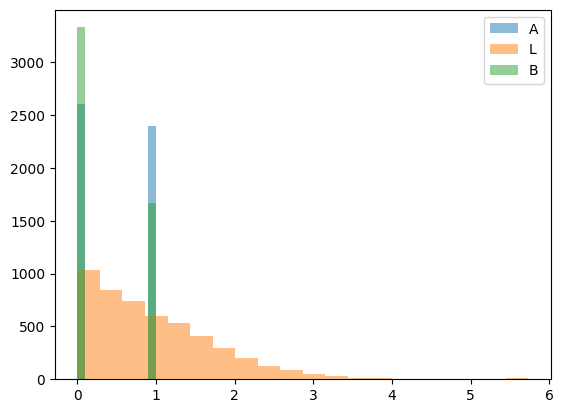

In [22]:
plt.hist(didilez_samples['a'], label='A', alpha=0.5);
plt.hist(didilez_samples['l'], label='L', alpha=0.5, bins=20);
plt.hist(didilez_samples['b'], label='B', alpha=0.5);
plt.legend();

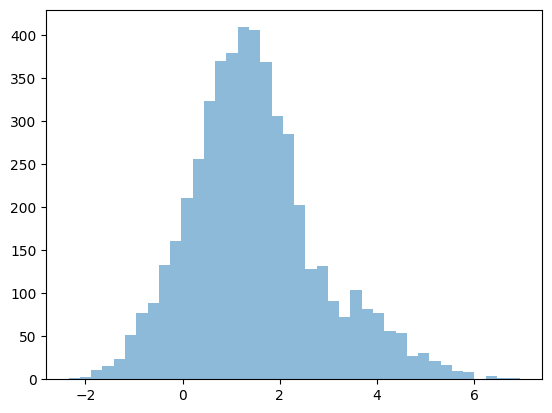

In [23]:
plt.hist(didilez_samples['y'], label='Y', alpha=0.5, bins=40);